In [30]:
import numpy as np
import pandas as pd
from collections import Counter
import pickle
import string
import matplotlib.pyplot as plt
%matplotlib inline
import re

In [445]:
comments = pickle.load(open('data/comments_df.dat', 'rb'))

In [446]:
# initial filtering
mod_message = 'Hi there, thank you for your submission! To be rated on /r/Rateme, a verification picture is required as stated in Rule 8. **One photo should include a HANDMADE sign that says /r/RateMe, and your EXACT Reddit username. Your face must be identifiable in the picture. If you have not added a verification picture, please make a new post that includes one as your current post will not appear.** All posts are manually approved by a moderator. Moderators reserve the right to question the authenticity of any submission. \n\nIf your current post **does** include your verification, sit back and relax! It will appear after a little while. If your submission does not appear within 16 hours, please message the moderator team. Thank you for your patience and cooperation!\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/Rateme) if you have any questions or concerns.*'
comments = comments[mod_message != comments.body.values]

overwritten_message_part = 'This comment has been overwritten by'
comments = comments[~comments.body.str.contains(overwritten_message_part)]

In [447]:
comments.body = comments.body.str.replace('out of', '/')
comments.body = comments.body.str.replace(' / ', '/')
comments.body = comments.body.str.replace(',','.')  # to parse floats correctly
comments.body = comments.body.str.replace('ish', '') # to parse 8ish
comments.body = comments.body.str.replace(':3', '') # to parse numbers correctly

In [449]:
comments.index = comments.created
comments['body_len'] = comments.body.str.len()

In [27]:
# Counter(comments.score.values).most_common()
# also score vs submitter
# len(name) vs avg rating

In [402]:
# comments.resample('M').mean().body_len.plot(figsize=(20, 10))

In [31]:
# Counter(df.name).most_common() # core group of commenters

In [321]:
# s = 'Nervous, but I\'ll give it a shot.ba[M]r 6.6-10'
# translator = str.maketrans('','',string.punctuation)
# s.translate(translator)

'Nervous but Ill give it a shotbaMr 6610'

In [450]:
# num_comments = comments[comments.body.str.contains('\d', regex=True)] # 90K/155K. for debug

In [455]:
# unnum_comments = comments[~comments.body.str.contains('\d', regex=True)]

In [457]:
def extract_rating(body):
    cut_indices_list = []
    final = 0
    final_counter = 0
    
    # parse ratings with slashes like 6.5/10
    slash_list = [c.start() for c in re.finditer('/', body)]
    if len(slash_list) > 0:
        for slash_index in slash_list:
            try:
                denom_str = body[slash_index+1 :].split(' ')[0]
                while not denom_str[-1].isdigit() and len(denom_str) > 0:
                    denom_str = denom_str[:-1]
                denom = float(denom_str)
                if denom == 0:
                    continue
            
                num_str = body[:slash_index].rsplit(' ')[-1]
                while not num_str[0].isdigit() and len(num_str) > 0:
                    num_str = num_str[1:]
                
                if '-' in num_str:
                    from_to_list = num_str.split('-')
                    if len(from_to_list) != 2:
                        continue
                    from_num = float(from_to_list[0])
                    to_num = float(from_to_list[1])
                    num = np.mean([from_num, to_num])
                else:
                    num = float(num_str)
                
                rating = num * 10 / denom
                rating = np.clip(rating, 0, 10)
                
                final += rating
                final_counter += 1
                
                cut_from = slash_index - len(num_str)
                cut_to = slash_index + len(denom_str) + 1
                cut_indices_list.append([cut_from, cut_to])
            except:
                pass
            
    # now extract ordinary numbers from what's left
    plain_num_pattern = '[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?'
#     if 'pic' not in body: # numbers probably don't refer to the ordering of pictures
    cut_body = body[:]
    for cut_indices in reversed(cut_indices_list): # cut from the end of the comment to the beginning
        cut_from, cut_to = cut_indices
        cut_body = cut_body[:cut_from] + cut_body[cut_to:]

    for m in re.finditer(plain_num_pattern, cut_body):
        chars_around = []
        if m.start() > 0:
            prev_char = cut_body[m.start() - 1]
            chars_around.append(prev_char)
        if m.end() < len(cut_body) - 1:
            next_char = cut_body[m.end() + 1]
            chars_around.append(next_char)
        for char in chars_around:
            if ((char not in string.punctuation and
                char not in string.whitespace) or
                char in '\'%"'):
                    continue
        rating_str = cut_body[m.start() : m.end()]
        try:
            rating = abs(float(rating_str))
            if rating >= 0 and rating <= 10:
                final += rating
                final_counter += 1
        except:
            pass
                
    if final_counter > 0 and final_counter <= 5:
        return final / final_counter
    else:
        return np.nan

In [452]:
# bodies = num_comments.sample(300).body

In [453]:
# for i, body in enumerate(bodies.values):
#     print('#' + str(i) + '. ' + body)
#     rating = extract_rating(body)
#     if not np.isnan(rating):
#         print()
#         print('***' + str(rating) + '***')
#         print()

#0. 6.4/10

***6.4***

#1. 9/10!!!!!! Omg Thank you:))) you definitely have made my day

***9.0***

#2. Rate/10?

***10.0***

#3. Top model for sure. especially from the first lot the photos 1.2.3 and 6. Just imagine a brand like Oakley. Levi. ... :-) Type in top mal model in google images and I think you would beat most of them. Have an awesome proud and confident 2016 :-)

***2.5***

#4. pretty. girlfriend material. I like the photo title "all fancy n shit" 7.5 to me

***7.5***

#5. Ridiculously hot.  Should be illegal and im glad its not. 9-10

***9.5***

#6. I'd give you an 8. a body shot would probably increase it

***8.0***

#7. Good username. Awful shirt. Face 6 or 7/10. It's hard to tell

***6.5***

#8. 8/10 awesome smile

***8.0***

#9. 8/10


***8.0***

#10. Wow 9/10. Very attractive. Nude pics are very sexy. 😍

***9.0***

#11. You are a 5 but could have a higher rating if you do your hair. make up and fix eyebrow. The Mallgoth look has got to go. Maybe moving to more solid c

In [470]:
comments['rating'] = comments.body.apply(extract_rating)

In [473]:
pickle.dump(comments, open('data/comments_with_ratings_df.dat', 'wb'))

In [480]:
ratings = comments.rating.values

In [481]:
ratings = ratings[~np.isnan(ratings)]

(array([  1027.,   2135.,   3610.,   5797.,   8695.,  14618.,  23846.,
         33836.,  29190.,  20790.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 <a list of 10 Patch objects>)

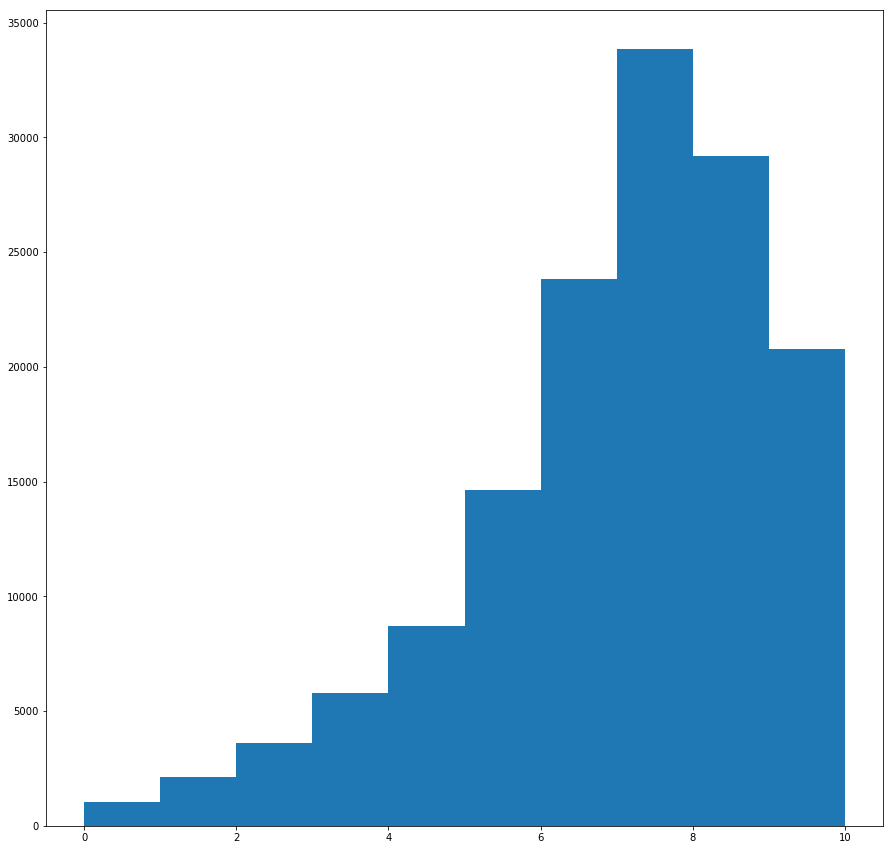

In [487]:
plt.figure(figsize=(15, 15))
plt.hist(ratings, bins=10)